## Retrieve Data from DB and Flatten

In [55]:
#Import neccesary libraries
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

In [8]:
#Connect to sqlite file
db = sqlite3.connect('exercise01.sqlite')

In [41]:
#SQL query to flatten database into single file
sql_flatten = """
SELECT records.id, age, 
countries.name as "country", education_levels.name as "education_level", education_num,
workclasses.name as "workclass", marital_statuses.name as "marital_status",
occupations.name as "occupation", races.name as "race", relationships.name as "relationship_status",
sexes.name as "sex",capital_gain, capital_loss,  hours_week, over_50k
FROM records
JOIN countries ON records.country_id = countries.id
JOIN education_levels ON records.education_level_id = education_levels.id
JOIN workclasses ON records.workclass_id = workclasses.id
JOIN marital_statuses ON records.marital_status_id = marital_statuses.id
JOIN occupations ON records.occupation_id = occupations.id
JOIN races ON records.race_id = races.id
JOIN relationships ON records.relationship_id = relationships.id
JOIN sexes ON records.sex_id = sexes.id
"""

flattened = pd.read_sql_query(sql_flatten, db, index_col = "id")
flattened.head()

,age,country,education_level,education_num,workclass,marital_status,occupation,race,relationship_status,sex,capital_gain,capital_loss,hours_week,over_50k
id,,,,,,,,,,,,,,
1,39,United-States,Bachelors,13,State-gov,Never-married,Adm-clerical,White,Not-in-family,Male,2174,0,40,0
2,50,United-States,Bachelors,13,Self-emp-not-inc,Married-civ-spouse,Exec-managerial,White,Husband,Male,0,0,13,0
3,38,United-States,HS-grad,9,Private,Divorced,Handlers-cleaners,White,Not-in-family,Male,0,0,40,0
4,53,United-States,11th,7,Private,Married-civ-spouse,Handlers-cleaners,Black,Husband,Male,0,0,40,0
5,28,Cuba,Bachelors,13,Private,Married-civ-spouse,Prof-specialty,Black,Wife,Female,0,0,40,0


In [33]:
#Check query didnt change size of records, should be 0,0
records = pd.read_sql_query("SELECT * FROM records", db)
np.subtract(flattened.shape,records.shape)


array([0, 0])

In [42]:
#write flattened database to csv file in local directory, using the id column as index
flattened.to_csv("flattened.csv",index_label = "id" )

## Read data from csv, handle missing data

In [120]:
#read the csv file into a pandas dataframe
flat_df = pd.read_csv("flattened.csv", index_col = 0,na_values = "?")
flat_df.head()

,age,country,education_level,education_num,workclass,marital_status,occupation,race,relationship_status,sex,capital_gain,capital_loss,hours_week,over_50k
id,,,,,,,,,,,,,,
1,39,United-States,Bachelors,13,State-gov,Never-married,Adm-clerical,White,Not-in-family,Male,2174,0,40,0
2,50,United-States,Bachelors,13,Self-emp-not-inc,Married-civ-spouse,Exec-managerial,White,Husband,Male,0,0,13,0
3,38,United-States,HS-grad,9,Private,Divorced,Handlers-cleaners,White,Not-in-family,Male,0,0,40,0
4,53,United-States,11th,7,Private,Married-civ-spouse,Handlers-cleaners,Black,Husband,Male,0,0,40,0
5,28,Cuba,Bachelors,13,Private,Married-civ-spouse,Prof-specialty,Black,Wife,Female,0,0,40,0


In [121]:
flat_df.isnull().sum()

age                       0
country                 857
education_level           0
education_num             0
workclass              2799
marital_status            0
occupation             2809
race                      0
relationship_status       0
sex                       0
capital_gain              0
capital_loss              0
hours_week                0
over_50k                  0
dtype: int64

No missing values for most variables. Workclass and occupation missing a few thousand, Country missing ~860. Could replace with mode (most common occurence) of each variable. Could use regression or nearest neighbors to predict missing values. The last option is to simply drop the missing values. As this is at most 2809/48842 = ~5.7% of the data, I am going to replace the missing values with the mode for the column. I am also going to make a df where I drop all the missign values

In [148]:
flat_df_clean = flat_df.apply(lambda x:x.fillna(x.value_counts().index[0]))
flat_df_clean.isnull().sum()

age                    0
country                0
education_level        0
education_num          0
workclass              0
marital_status         0
occupation             0
race                   0
relationship_status    0
sex                    0
capital_gain           0
capital_loss           0
hours_week             0
over_50k               0
dtype: int64

In [125]:
flat_df_dropped = flat_df.dropna(inplace=False)
flat_df_dropped.isnull().sum()
np.subtract(flat_df_dropped.shape,flat_df.shape)#3620 rows dropped, lose around 7 percent of data

array([-3620,     0])

## Exploratory Analysis and Visualization

In [113]:
flat_df_clean.describe()

,age,education_num,capital_gain,capital_loss,hours_week,over_50k
count,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,10.078089,1079.067626,87.502314,40.422382,0.239282
std,13.710510,2.570973,7452.019058,403.004552,12.391444,0.426649
min,17.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000,0.000000
75%,48.000000,12.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000,1.000000


Average age: 38.6 years old. Capital gain, capital loss very skewed towards zero. Some extremes but less than 25% of data is nonzero. 40.4 hours per week is average, which is expected. around 24 percent of individuals make over_50k. This is not a perfectly balanced dataset on the two classes, but is not unbalanced enough to do any rebalancing.

In [114]:
catcols = flat_df_clean.select_dtypes(exclude=["int64"])
numcols = flat_df_clean.select_dtypes(include=["int64"])


In [143]:
for col in catcols:
    print(col.capitalize(),flat_df_clean[col].value_counts().index[0],flat_df_clean[col].value_counts()[0])

Country United-States 44689
Education_level HS-grad 15784
Workclass Private 36705
Marital_status Married-civ-spouse 22379
Occupation Prof-specialty 8981
Race White 41762
Relationship_status Husband 19716
Sex Male 32650


The most common values of each categorical variable are listed above followed by the number of times that value occurs in the data set

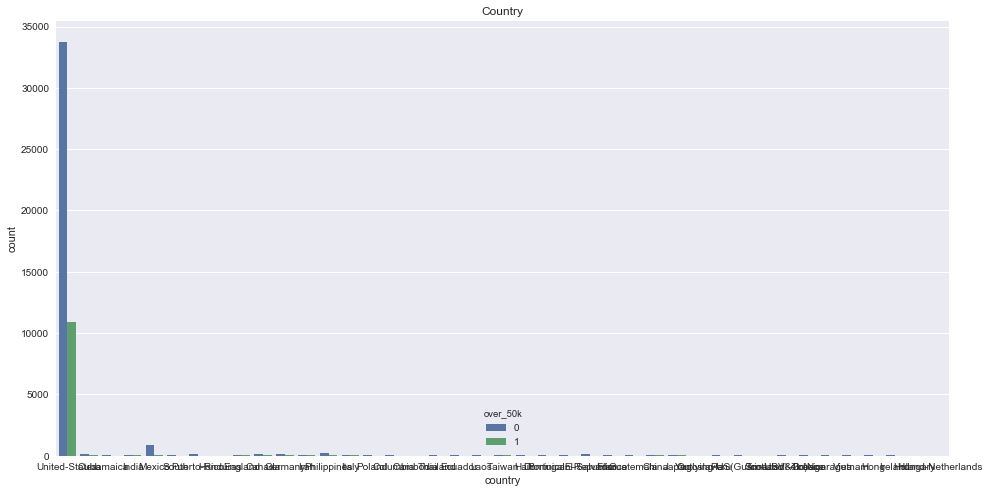

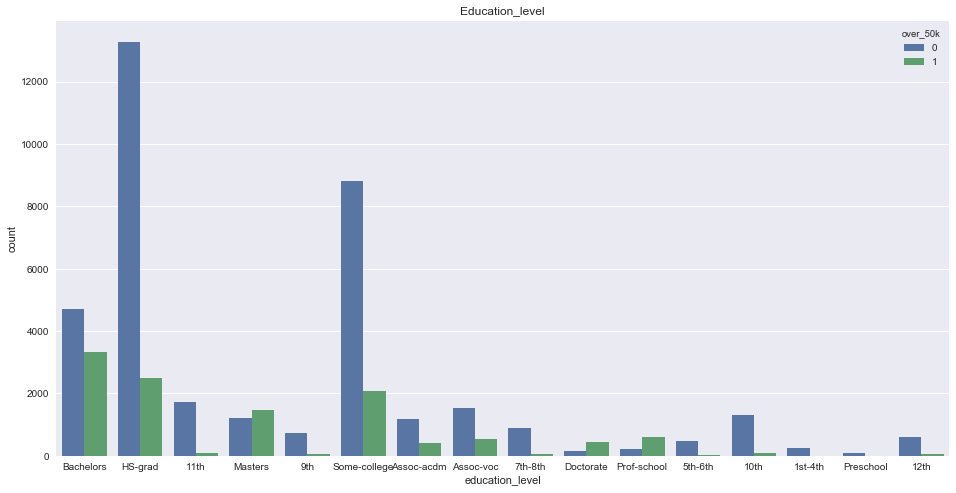

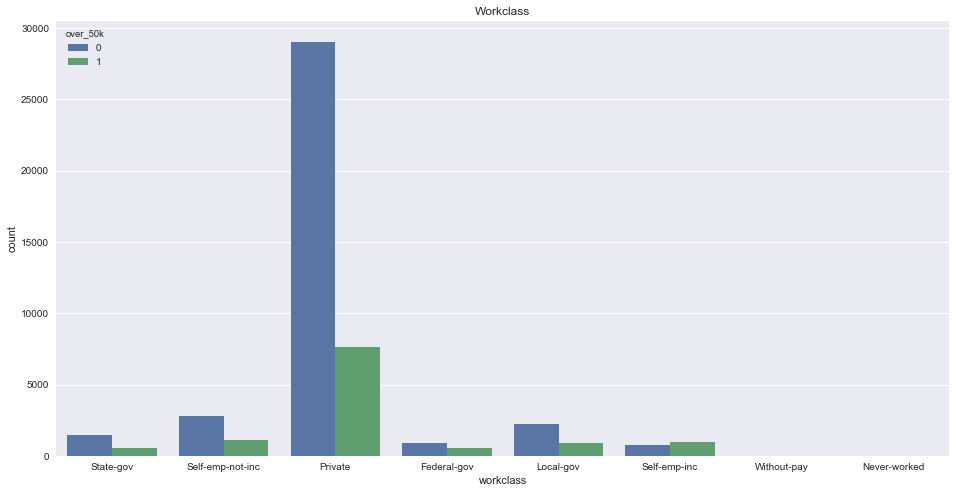

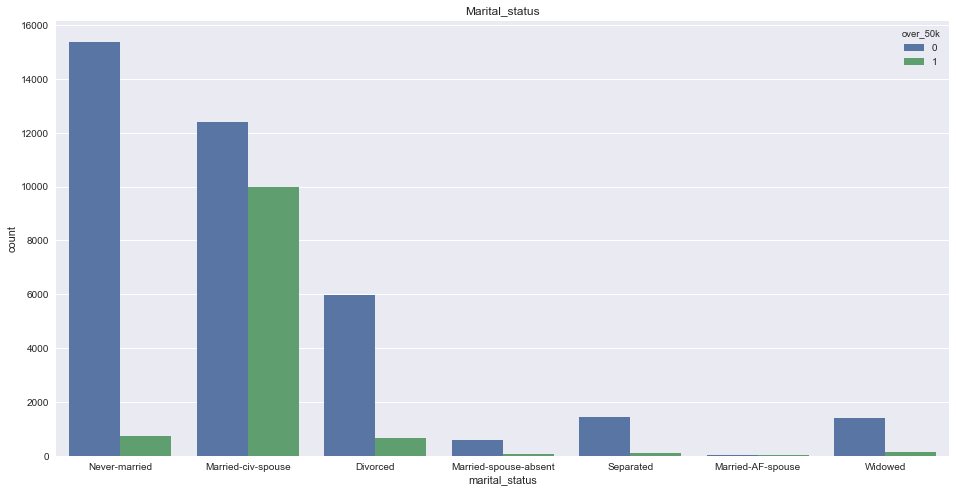

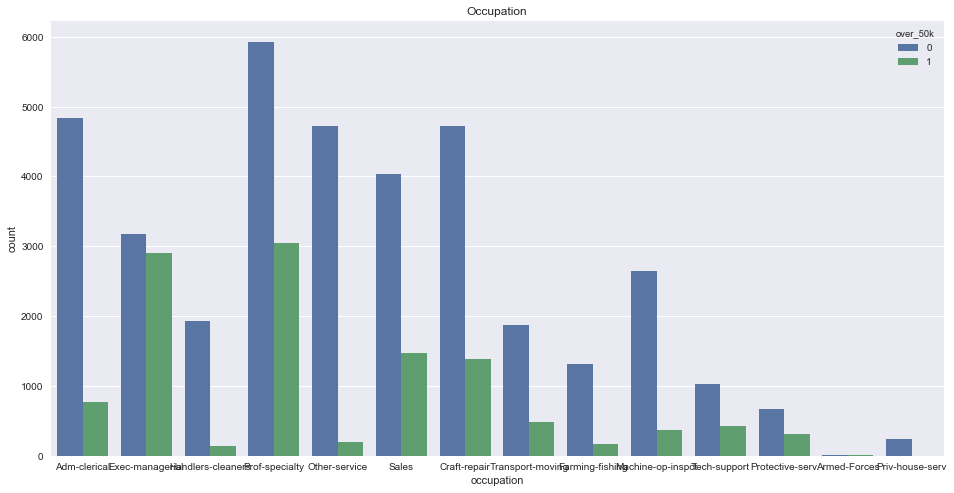

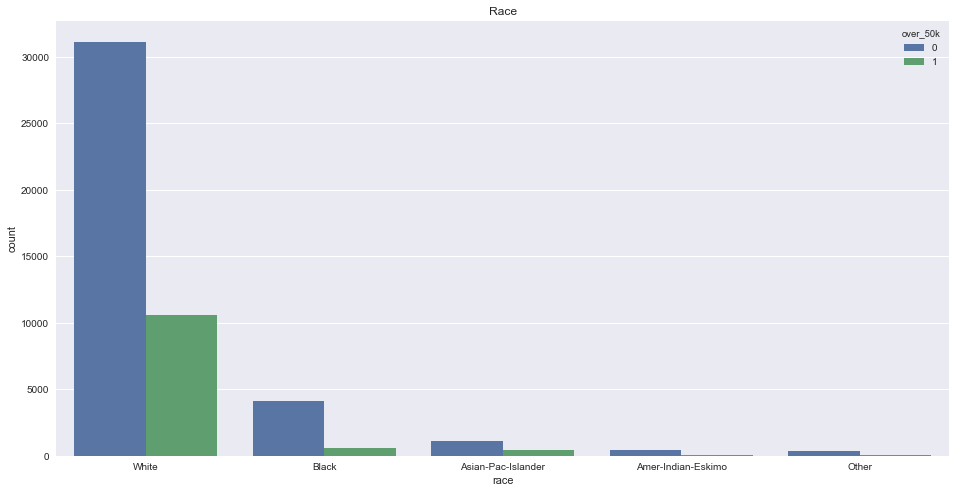

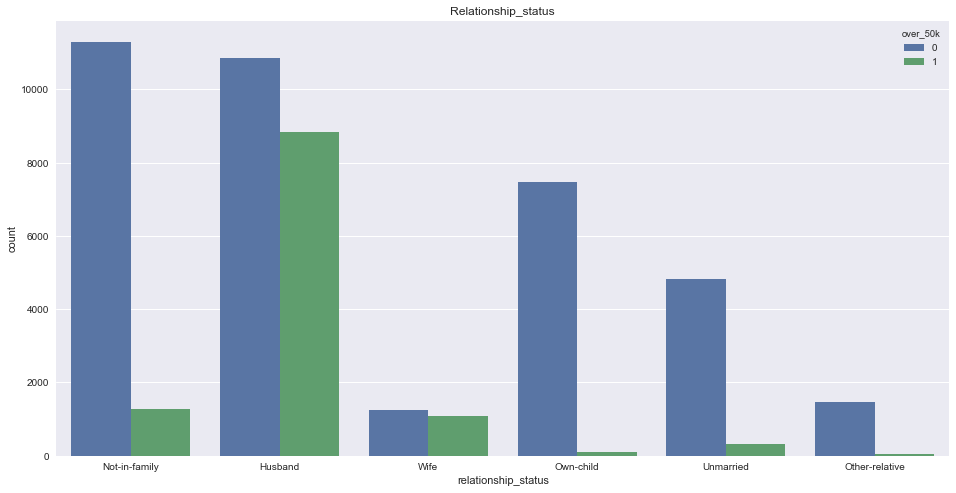

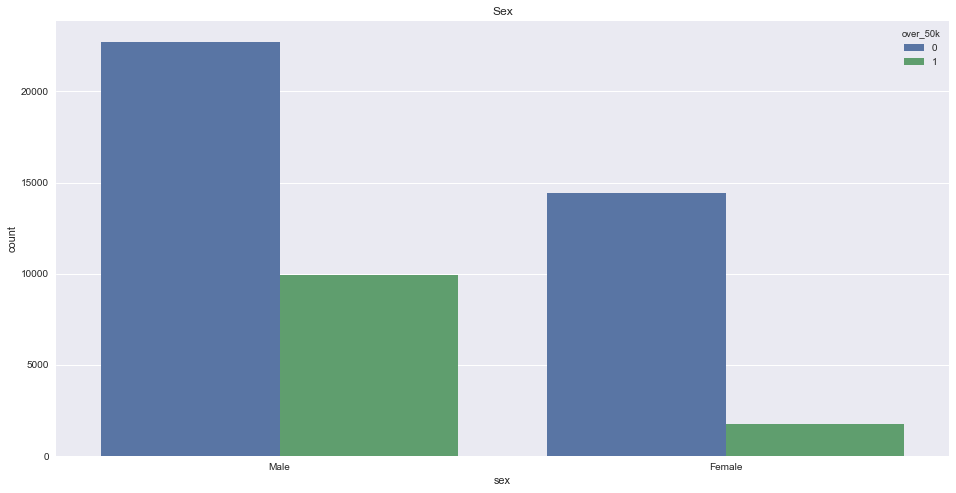

In [115]:
#set graph size
sns.set(rc={'figure.figsize':(16,8)})
for col in catcols:
    sns_plot = sns.countplot(col,hue = "over_50k",data = flat_df_clean).set_title(col.capitalize())
    plt.show()
    fig = sns_plot.get_figure() 
    fig.savefig("./plots/"+col+".png")

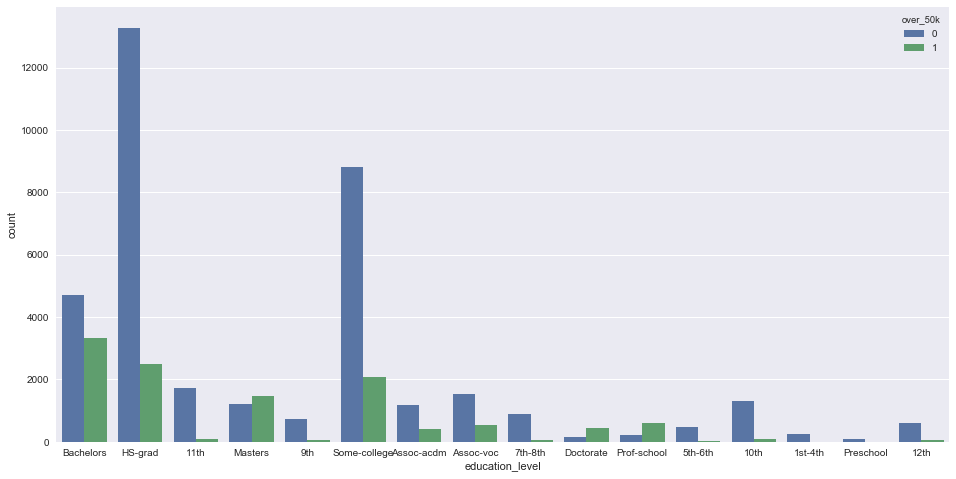

In [99]:
sns_plot = sns.countplot("education_level",hue = "over_50k",data = flat_df)

The above plot is interesting. Doctorate, Prof-school and Masters are all education levels where you are more likely to be making above 50k than below. For this reason, education level will likely be a helpful factor in the model

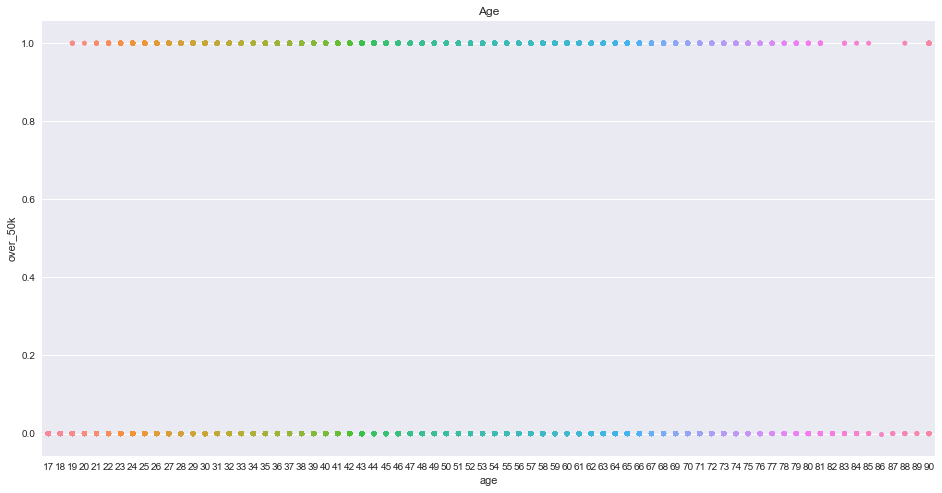

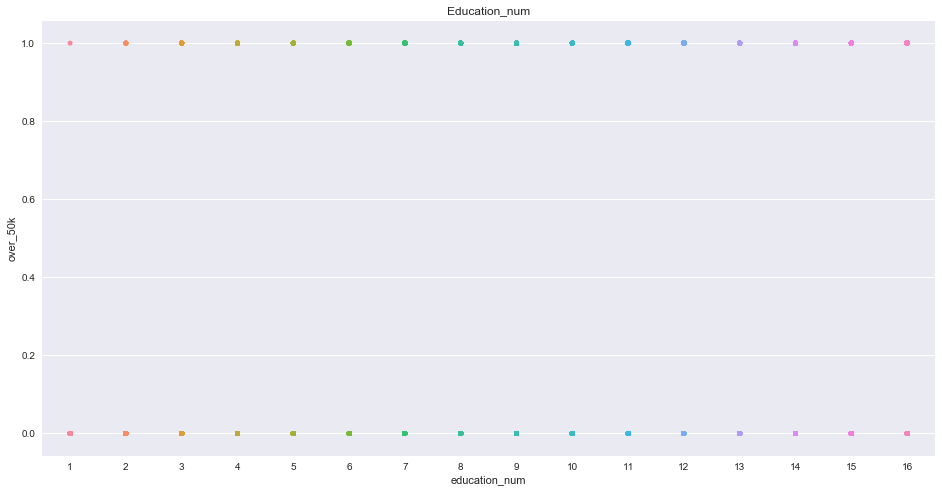

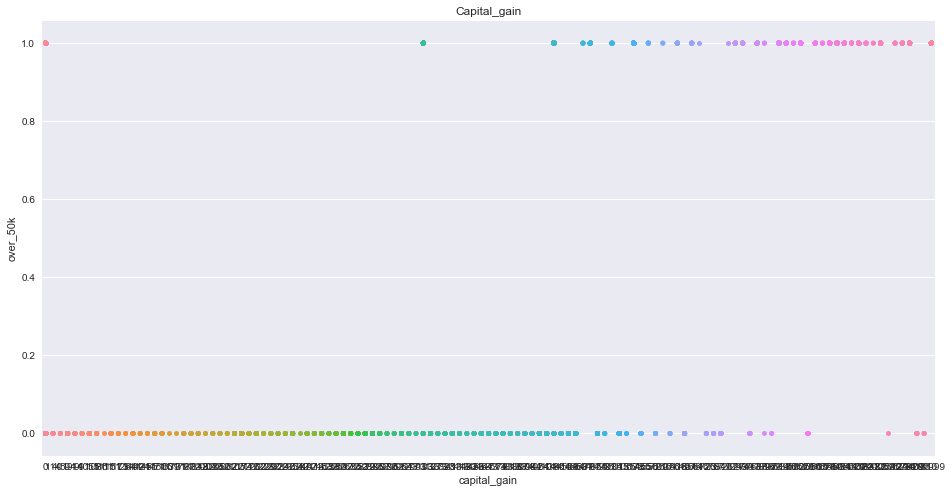

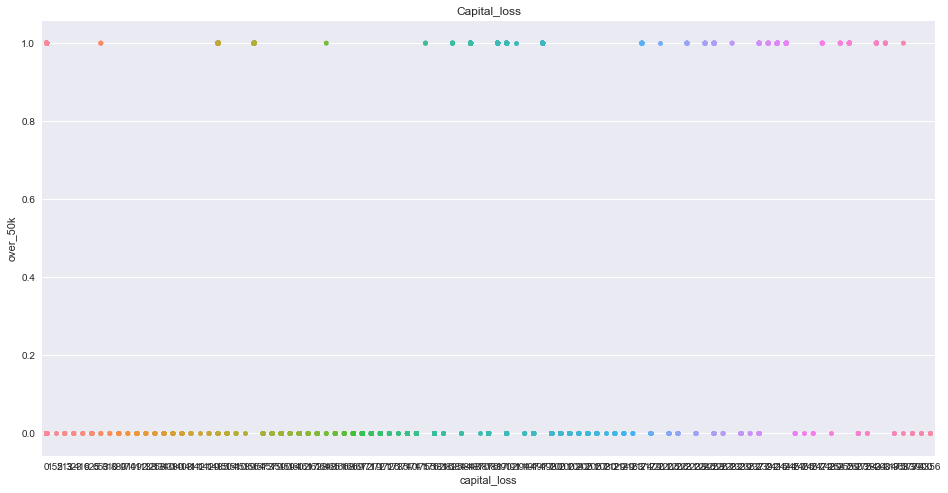

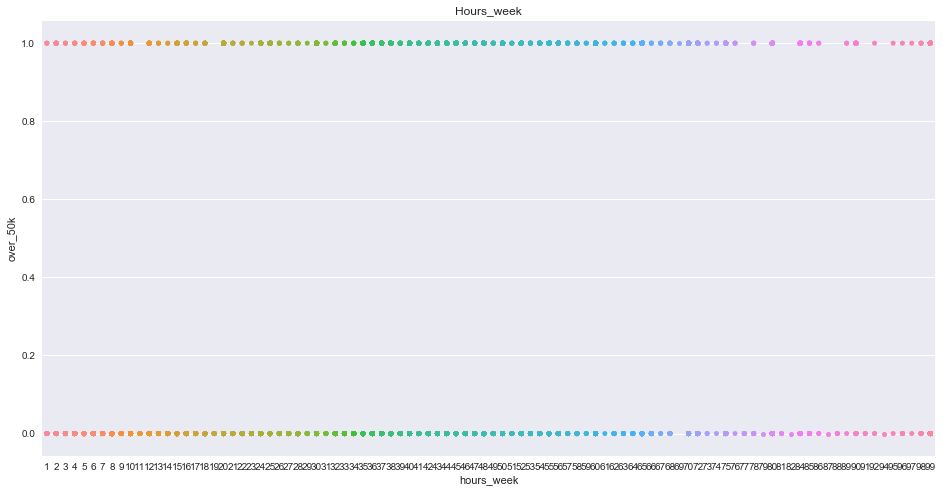

In [105]:
for col in numcols:
    if col == "over_50k": continue
    sns_plot = sns.stripplot(col,"over_50k",data = flat_df).set_title(col.capitalize())
    plt.show()
    fig = sns_plot.get_figure() 
    fig.savefig("./plots/"+col+".png")

Above graphs arent exceedingly valuable. Capital gains shows that at low gains, but nonzero, its likely to be under 50k, while at high gains its likely to be above 50k. Rest of the graphs in this format dont contain a lot of information

## Data Encoding and Splitting

In [151]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
flat_enc_df = pd.get_dummies(flat_df_clean, drop_first = True)
flat_enc_df.describe()

,age,education_num,capital_gain,capital_loss,hours_week,over_50k,country_Canada,country_China,country_Columbia,country_Cuba,...,race_Asian-Pac-Islander,race_Black,race_Other,race_White,relationship_status_Not-in-family,relationship_status_Other-relative,relationship_status_Own-child,relationship_status_Unmarried,relationship_status_Wife,sex_Male
count,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,...,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,10.078089,1079.067626,87.502314,40.422382,0.239282,0.003726,0.002498,0.001740,0.002825,...,0.031100,0.095922,0.008313,0.855043,0.257627,0.030834,0.155215,0.104930,0.047725,0.668482
std,13.710510,2.570973,7452.019058,403.004552,12.391444,0.426649,0.060930,0.049917,0.041681,0.053080,...,0.173591,0.294487,0.090794,0.352061,0.437332,0.172870,0.362113,0.306467,0.213187,0.470764
min,17.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,48.000000,12.000000,0.000000,0.000000,45.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [158]:
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(flat_enc_df.drop("over_50k",axis = 1), 
                                                    flat_enc_df["over_50k"], test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.2, random_state=1)

## Model Selection

I plan to use two methods of model selection:
1. Traditional train, test, validation split
2. k-fold cross validation on just a train and validation set